In [15]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, f1_score
from textblob import TextBlob
import nltk
from nltk.corpus import wordnet
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, LayerNormalization, Bidirectional, Concatenate, GlobalMaxPooling1D, Attention
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [2]:
# Load the datasets
train = pd.read_json('Dataset/train.jsonl', lines=True)
test = pd.read_json('Dataset/test.jsonl', lines=True)
val = pd.read_json('Dataset/val.jsonl', lines=True)   

In [3]:
train.head()

,uuid,postId,postText,postPlatform,targetParagraphs,targetTitle,targetDescription,targetKeywords,targetMedia,targetUrl,provenance,spoiler,spoilerPositions,tags
0,0af11f6b-c889-4520-9372-66ba25cb7657,532quh,"[Wes Welker Wanted Dinner With Tom Brady, But ...",reddit,[It’ll be just like old times this weekend for...,"Wes Welker Wanted Dinner With Tom Brady, But P...",It'll be just like old times this weekend for ...,"new england patriots, ricky doyle, top stories,","[http://pixel.wp.com/b.gif?v=noscript, http://...",http://nesn.com/2016/09/wes-welker-wanted-dinn...,"{'source': 'anonymized', 'humanSpoiler': 'They...",[how about that morning we go throw?],"[[[3, 151], [3, 186]]]",[passage]
1,b1a1f63d-8853-4a11-89e8-6b2952a393ec,411701128456593408,[NASA sets date for full recovery of ozone hole],Twitter,[2070 is shaping up to be a great year for Mot...,Hole In Ozone Layer Expected To Make Full Reco...,2070 is shaping up to be a great year for Moth...,"ozone layer,ozone hole determined by weather,M...",[http://s.m.huffpost.com/assets/Logo_Huffingto...,http://huff.to/1cH672Z,"{'source': 'anonymized', 'humanSpoiler': '2070...",[2070],"[[[0, 0], [0, 4]]]",[phrase]
2,008b7b19-0445-4e16-8f9e-075b73f80ca4,380537005123190784,[This is what makes employees happy -- and it'...,Twitter,"[Despite common belief, money isn't the key to...",Intellectual Stimulation Trumps Money For Empl...,By: Chad Brooks \r\nPublished: 09/18/2013 06:4...,"employee happiness money,employee happiness in...",[http://i.huffpost.com/gen/1359674/images/o-HA...,http://huff.to/1epfeaw,"{'source': 'anonymized', 'humanSpoiler': 'Inte...",[intellectual stimulation],"[[[1, 186], [1, 210]]]",[phrase]
3,31ecf93c-3e21-4c80-949b-aa549a046b93,844567852531286016,[Passion is overrated — 7 work habits you need...,Twitter,"[It’s common wisdom. Near gospel really, and n...","‘Follow your passion’ is wrong, here are 7 hab...",There's a lot more to work that loving your job,"business, work-life, careers",None,None,"{'source': 'anonymized', 'humanSpoiler': None,...",[Purpose connects us to something bigger and i...,"[[[11, 25], [11, 101]], [[17, 56], [17, 85]], ...",[multi]
4,31b108a3-c828-421a-a4b9-cf651e9ac859,814186311573766144,[The perfect way to cook rice so that it's per...,Twitter,"[Boiling rice may seem simple, but there is a ...",Revealed: The perfect way to cook rice so that...,The question 'How does one cook rice properly?...,"Quora,users,share,perfect,way,cook,rice",None,None,"{'source': 'anonymized', 'humanSpoiler': None,...",[in a rice cooker],"[[[5, 60], [5, 76]]]",[phrase]


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3200 entries, 0 to 3199
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   uuid               3200 non-null   object
 1   postId             3200 non-null   object
 2   postText           3200 non-null   object
 3   postPlatform       3200 non-null   object
 4   targetParagraphs   3200 non-null   object
 5   targetTitle        3200 non-null   object
 6   targetDescription  2933 non-null   object
 7   targetKeywords     2116 non-null   object
 8   targetMedia        2685 non-null   object
 9   targetUrl          2717 non-null   object
 10  provenance         3200 non-null   object
 11  spoiler            3200 non-null   object
 12  spoilerPositions   3200 non-null   object
 13  tags               3200 non-null   object
dtypes: object(14)
memory usage: 350.1+ KB


In [5]:
val.head()

,postId,postText,postPlatform,targetParagraphs,targetTitle,targetDescription,targetKeywords,targetMedia,targetUrl,provenance,spoiler,spoilerPositions,tags,id
0,800048986762423_885081814925806,[Five Nights at Freddy’s Sequel Delayed for We...,Facebook,[Five Nights at Freddy’s creator Scott Cawthon...,Five Nights at Freddy’s Sequel Delayed for Wei...,Five Nights at Freddy's creator Scott Cawthon ...,None,[https://gamerant.com/wp-content/uploads/five-...,https://gamerant.com/five-nights-at-freddys-se...,"{'source': 'anonymized', 'humanSpoiler': 'They...",[some of the plot elements are so disturbing t...,"[[[2, 158], [2, 236]]]",[passage],0
1,4jp20e,[Why Arizona Sheriff Joe Arpaio’s fate could h...,reddit,[© REUTERS/Laura Segall Maricopa County Sherif...,Why Arizona Sheriff Joe Arpaio’s fate could ha...,"<p>A single word — ""intentionally"" — could tra...",None,[https://archive.is/0eGBT/bbf6d79b366fc7e75b8b...,https://archive.is/0eGBT,"{'source': 'anonymized', 'humanSpoiler': '""Int...","[""intentionally"", could transform a court case...","[[[0, 197], [0, 212]], [[0, 215], [0, 328]]]",[multi],1
2,857559227384160256,[Here’s how much you should be tipping your ha...,Twitter,[Here’s how much you should be tipping your ha...,Here’s how much you should be tipping your hai...,Remembering how much you’re supposed to tip an...,,None,None,"{'source': 'anonymized', 'humanSpoiler': None,...",[20%],"[[[3, 58], [3, 61]]]",[phrase],2
3,389091583213453312,"[""Harry Potter"" alums reunite for new movie]",Twitter,[The mythology of punk music's evolution can b...,"Alan Rickman & Rupert Grint On 'CBGB,' Reuniti...",The mythology of punk music's evolution can be...,"Alan Rickman,Hilly Kristal,new rupert grint mo...",[http://s.m.huffpost.com/assets/Logo_Huffingto...,http://huff.to/1ccNwKJ,"{'source': 'anonymized', 'humanSpoiler': 'Alan...","[Alan Rickman & Rupert Grint, CBGB]","[[[-1, 0], [-1, 27]], [[0, 98], [0, 102]]]",[multi],3
4,744740593046274048,[A man swallowed a microSD card and you won't ...,Twitter,[PetaPixel is one of my favorite blogs. The wr...,Man swallowed a microSD card and you won't bel...,PetaPixel is one of my favorite blogs. The wri...,None,[https://cdn0.vox-cdn.com/uploads/chorus_image...,http://www.theverge.com/circuitbreaker/2016/6/...,"{'source': 'anonymized', 'humanSpoiler': 'This...",[a man who swallowed a 64GB microSD card and t...,"[[[1, 34], [1, 108]]]",[passage],4


In [6]:
val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   postId             400 non-null    object
 1   postText           400 non-null    object
 2   postPlatform       400 non-null    object
 3   targetParagraphs   400 non-null    object
 4   targetTitle        400 non-null    object
 5   targetDescription  367 non-null    object
 6   targetKeywords     269 non-null    object
 7   targetMedia        334 non-null    object
 8   targetUrl          340 non-null    object
 9   provenance         400 non-null    object
 10  spoiler            400 non-null    object
 11  spoilerPositions   400 non-null    object
 12  tags               400 non-null    object
 13  id                 400 non-null    int64 
dtypes: int64(1), object(13)
memory usage: 43.9+ KB


In [7]:
test.head()

,postId,postText,postPlatform,targetParagraphs,targetTitle,targetDescription,targetKeywords,targetMedia,targetUrl,id
0,170016066732231_222926014774569,[He Tackles A Nurse At The Hospital. Then You ...,Facebook,"[When you think about your good friends, many ...",Male Nurse Breaks Down When His Friend Reveals...,"When you think about your good friends, many t...",None,[https://cdn0.littlethings.com/app/uploads/201...,http://www.littlethings.com/surprise-gift-kidn...,0
1,828732026186563584,[Why you SHOULD be selfish at work],Twitter,[We're always being encouraged to help others ...,Why you SHOULD be selfish at work: Helping oth...,Wharton School of the University of Pennsylvan...,"Why,selfish,work",None,None,1
2,721323075246112769,[The one strange trick that will make you live...,Twitter,[Meditating inside a beautiful stock-photo roo...,The One Strange Trick That Will Help You Live ...,A new study showed that the wealthy are living...,"culture, news, lgbtq, politics, journalism, vi...",[https://vice-images.vice.com/images/content-i...,http://bit.ly/1SbRoUK,2
3,51a6xo,[Nerd Wins Scrabble Championship With Word You...,reddit,"[Image: Getty, As you probably already know, t...",Nerd Wins Scrabble Championship With Word You’...,"As you probably already know, the World Scrabb...","good vocabularies, scrabble, braconid, Gizmodo","[data:image/gif;base64,R0lGODlhAQABAAAAACH5BAE...",http://archive.is/0z4xs,3
4,54dxh0,[The bizarre new way to eat eggs that has ever...,reddit,[Cured egg yolks are delicious—but strong. Bec...,The Bizarre New Way To Eat Eggs That Has Every...,"Forget frying, poaching, or hard-boiling. Thes...",None,[http://www.rodalesorganiclife.com/sites/rodal...,http://www.rodalesorganiclife.com/food/the-biz...,4


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   postId             400 non-null    object
 1   postText           400 non-null    object
 2   postPlatform       400 non-null    object
 3   targetParagraphs   400 non-null    object
 4   targetTitle        400 non-null    object
 5   targetDescription  363 non-null    object
 6   targetKeywords     241 non-null    object
 7   targetMedia        341 non-null    object
 8   targetUrl          343 non-null    object
 9   id                 400 non-null    int64 
dtypes: int64(1), object(9)
memory usage: 31.4+ KB


In [11]:
print("Train Columns:",train.columns)
print("Val Columns:",val.columns)
print("Test Columns:",test.columns)

Train Columns: Index(['uuid', 'postId', 'postText', 'postPlatform', 'targetParagraphs',
       'targetTitle', 'targetDescription', 'targetKeywords', 'targetMedia',
       'targetUrl', 'provenance', 'spoiler', 'spoilerPositions', 'tags',
       'combined_text', 'text_length', 'sentiment'],
      dtype='object')
Val Columns: Index(['postId', 'postText', 'postPlatform', 'targetParagraphs', 'targetTitle',
       'targetDescription', 'targetKeywords', 'targetMedia', 'targetUrl',
       'provenance', 'spoiler', 'spoilerPositions', 'tags', 'id'],
      dtype='object')
Test Columns: Index(['postId', 'postText', 'postPlatform', 'targetParagraphs', 'targetTitle',
       'targetDescription', 'targetKeywords', 'targetMedia', 'targetUrl',
       'id'],
      dtype='object')


In [13]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import StandardScaler, LabelEncoder
from textblob import TextBlob
import nltk
from nltk.corpus import wordnet
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, LayerNormalization, Bidirectional, Concatenate, GlobalMaxPooling1D, Attention
from tensorflow.keras.optimizers import Adam

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

# Load the datasets
train = pd.read_json('Dataset/train.jsonl', lines=True)
test = pd.read_json('Dataset/test.jsonl', lines=True)
val = pd.read_json('Dataset/val.jsonl', lines=True)

# Text cleaning function
def clean_text(text):
    if isinstance(text, list):
        text = ' '.join(map(str, text))
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    return text

# Sentiment analysis function
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Text augmentation function
def synonym_replacement(text):
    words = text.split()
    new_words = words.copy()
    for i in range(len(words)):
        synonyms = wordnet.synsets(words[i])
        if synonyms:
            synonym = synonyms[0].lemmas()[0].name()
            new_words[i] = synonym
    return ' '.join(new_words)

# Preprocess and feature engineering
def preprocess_data_extended(df, is_training=True):
    df['combined_text'] = df['postText'].astype(str) + ' ' + df['targetTitle'].astype(str) + ' ' + df['targetParagraphs'].astype(str)
    df['combined_text'] = df['combined_text'].apply(clean_text)
    df['text_length'] = df['combined_text'].str.len()
    df['sentiment'] = df['combined_text'].apply(get_sentiment)
    if is_training:
        df['spoiler'] = df['spoiler'].apply(clean_text)
    return df

# Apply extended preprocessing to all datasets
train = preprocess_data_extended(train, is_training=True)
val = preprocess_data_extended(val, is_training=True)
test = preprocess_data_extended(test, is_training=False)

# Augment training data
train['augmented_text'] = train['combined_text'].apply(synonym_replacement)
train['combined_text'] = train['combined_text'] + ' ' + train['augmented_text']

# Tokenize the texts
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['combined_text'].tolist() + val['combined_text'].tolist() + test['combined_text'].tolist())

# Convert texts to sequences
X_train = tokenizer.texts_to_sequences(train['combined_text'])
X_val = tokenizer.texts_to_sequences(val['combined_text'])
X_test = tokenizer.texts_to_sequences(test['combined_text'])

# Convert spoilers to sequences
y_train = tokenizer.texts_to_sequences(train['spoiler'])
y_val = tokenizer.texts_to_sequences(val['spoiler'])

# Pad sequences
maxlen_input = 512  # Adjust this based on your data
maxlen_output = 64  # Adjust this based on your data
X_train_padded = pad_sequences(X_train, maxlen=maxlen_input, padding='post')
X_val_padded = pad_sequences(X_val, maxlen=maxlen_input, padding='post')
X_test_padded = pad_sequences(X_test, maxlen=maxlen_input, padding='post')
y_train_padded = pad_sequences(y_train, maxlen=maxlen_output, padding='post')
y_val_padded = pad_sequences(y_val, maxlen=maxlen_output, padding='post')

# Get the vocabulary size
vocab_size = len(tokenizer.word_index) + 1

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/abiwaqasyasir/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/abiwaqasyasir/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/abiwaqasyasir/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [16]:
# Define the encoder
def build_encoder(vocab_size, embedding_dim, maxlen_input):
    encoder_inputs = Input(shape=(maxlen_input,))
    embedding_layer = Embedding(vocab_size, embedding_dim)(encoder_inputs)
    encoder_lstm = Bidirectional(LSTM(256, return_sequences=True, return_state=True))
    encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm(embedding_layer)
    state_h = Concatenate()([forward_h, backward_h])
    state_c = Concatenate()([forward_c, backward_c])
    return encoder_inputs, encoder_outputs, state_h, state_c

# Define the decoder
def build_decoder(vocab_size, embedding_dim, maxlen_output, encoder_outputs, state_h, state_c):
    decoder_inputs = Input(shape=(maxlen_output,))
    embedding_layer = Embedding(vocab_size, embedding_dim)(decoder_inputs)
    decoder_lstm = LSTM(512, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(embedding_layer, initial_state=[state_h, state_c])
    attention_layer = Attention()([decoder_outputs, encoder_outputs])
    decoder_concat_input = Concatenate(axis=-1)([decoder_outputs, attention_layer])
    decoder_dense = Dense(vocab_size, activation='softmax')
    decoder_outputs = decoder_dense(decoder_concat_input)
    return decoder_inputs, decoder_outputs

# Build the model
embedding_dim = 100
maxlen_input = 512
maxlen_output = 64

encoder_inputs, encoder_outputs, state_h, state_c = build_encoder(vocab_size, embedding_dim, maxlen_input)
decoder_inputs, decoder_outputs = build_decoder(vocab_size, embedding_dim, maxlen_output, encoder_outputs, state_h, state_c)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer=Adam(learning_rate=5e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Prepare decoder input data
decoder_input_data = np.zeros_like(y_train_padded)
decoder_input_data[:, 1:] = y_train_padded[:, :-1]
decoder_input_data[:, 0] = tokenizer.word_index.get('<start>', 1)

# Prepare decoder target data
decoder_target_data = np.expand_dims(y_train_padded, -1)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 512, 100)  │  7,828,600 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ [(None, 512,      │    731,136 │ embedding_2[0][0] │
│ (Bidirectional)     │ 512), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 64, 100)   │  7,828,600 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 512)       │          0 │ bidirectional_1[… │
│ (Concatenate)       │                   │            │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 512)       │          0 │ bidirectional_1[… │
│ (Concatenate)       │                   │            │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, 64, 512), │  1,255,424 │ embedding_3[0][0… │
│                     │ (None, 512),      │            │ concatenate_3[0]… │
│                     │ (None, 512)]      │            │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_1         │ (None, 64, 512)   │          0 │ lstm_3[0][0],     │
│ (Attention)         │                   │            │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 64, 1024)  │          0 │ lstm_3[0][0],     │
│ (Concatenate)       │                   │            │ attention_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64, 78286) │ 80,243,150 │ concatenate_5[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 97,886,910 (373.41 MB)

 Trainable params: 97,886,910 (373.41 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1134s 11s/step - accuracy: 0.7451 - loss: 5.6480 - val_accuracy: 0.7779 - val_loss: 2.4800
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1203s 12s/step - accuracy: 0.7864 - loss: 1.7375 - val_accuracy: 0.7779 - val_loss: 2.9648
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1122s 11s/step - accuracy: 0.7858 - loss: 1.6856 - val_accuracy: 0.7779 - val_loss: 3.1010
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1135s 11s/step - accuracy: 0.7838 - loss: 1.6912 - val_accuracy: 0.7779 - val_loss: 3.1934
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1196s 12s/step - accuracy: 0.7883 - loss: 1.6520 - val_accuracy: 0.7779 - val_loss: 3.2377
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1916s 19s/step - accuracy: 0.7871 - loss: 1.6487 - val_accuracy: 0.7779 - val_loss: 3.2739
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1847s 18s/step - accuracy: 0.7971 - loss: 1.5599 - val_accuracy: 0.7779 - val_loss: 3.2972
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 4378s 44s/step - accuracy: 0.7945 - loss: 1

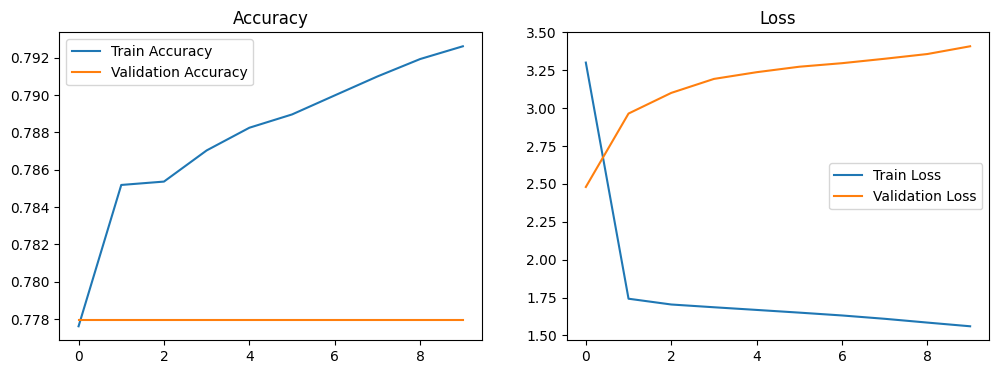

In [17]:
# Train the model and store history
history = model.fit([X_train_padded, decoder_input_data], decoder_target_data,
                    batch_size=32,
                    epochs=10,
                    validation_data=([X_val_padded, np.zeros_like(y_val_padded)], np.expand_dims(y_val_padded, -1)))

# Plot accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

In [19]:
 #Inference with beam search decoder
def beam_search_decoder(model, input_seq, beam_width=4):
    start_token = tokenizer.word_index.get('<start>', 1)
    end_token = tokenizer.word_index.get('<end>', 2)
    sequences = [[list(), 1.0]]
    input_seq = np.expand_dims(input_seq, axis=0)

    for _ in range(maxlen_output):
        all_candidates = list()
        for seq, score in sequences:
            if len(seq) > 0 and seq[-1] == end_token:
                all_candidates.append((seq, score))
                continue
            decoder_input = np.zeros((1, maxlen_output))
            decoder_input[0, :len(seq)] = seq
            predictions = model.predict([input_seq, decoder_input], verbose=0)
            top_k = np.argsort(predictions[0, len(seq)-1, :])[-beam_width:]
            for idx in top_k:
                candidate = [seq + [idx], score * -np.log(predictions[0, len(seq)-1, idx])]
                all_candidates.append(candidate)
        ordered = sorted(all_candidates, key=lambda tup: tup[1])
        sequences = ordered[:beam_width]
    return sequences[0][0]

In [ ]:
# Generate spoilers for the test set
generated_spoilers = []
for input_seq in X_test_padded:
    generated_seq = beam_search_decoder(model, input_seq)
    generated_text = ' '.join([tokenizer.index_word[idx] for idx in generated_seq if idx != 0])
    generated_spoilers.append(generated_text)

# Save the generated spoilers
test['generatedSpoiler'] = generated_spoilers
test.to_csv('generated_spoilers.csv', index=False)

# Calculate F1 score for the validation set
y_val_true = [item for sublist in y_val for item in sublist]
y_val_pred = model.predict([X_val_padded, np.zeros_like(y_val_padded)])
y_val_pred = np.argmax(y_val_pred, axis=-1).flatten()

f1 = f1_score(y_val_true, y_val_pred, average='weighted')
print(f'Validation F1 Score: {f1}')

# Print classification report
print(classification_report(y_val_true, y_val_pred, target_names=list(tokenizer.word_index.keys())))

In [20]:
sample= pd.read_csv('sample_solution_task2.csv')

In [21]:
sample.head()

,id,spoiler
0,0,"Woman Buys Doormat Off Amazon, Here’s What She..."
1,1,Something Unexpected Gave This Paralyzed Man H...
2,2,"In the Digital Age, is shopping America's new ..."
3,3,Snowshoer Who Fell Into Tree Well Survives Aft...
4,4,This Rock Seems Out Of Place. When He Moves It...


In [22]:
# Generate spoilers for the test set
generated_spoilers = []
for input_seq in X_test_padded:
    generated_seq = beam_search_decoder(model, input_seq)
    generated_text = ' '.join([tokenizer.index_word[idx] for idx in generated_seq if idx != 0])
    generated_spoilers.append(generated_text)

# Create a DataFrame with id and spoiler columns
results_df = pd.DataFrame({
    'id': range(len(generated_spoilers)),
    'spoiler': generated_spoilers
})

# Save the generated spoilers to a CSV file
results_df.to_csv('generated_spoilers.csv', index=False)

print("Generated spoilers saved to 'generated_spoilers.csv'")

Generated spoilers saved to 'generated_spoilers.csv'
